In [1]:
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In [5]:
%pwd

'/Users/seyeong/workspace/Upstage_team3/deep_research/dev_test'

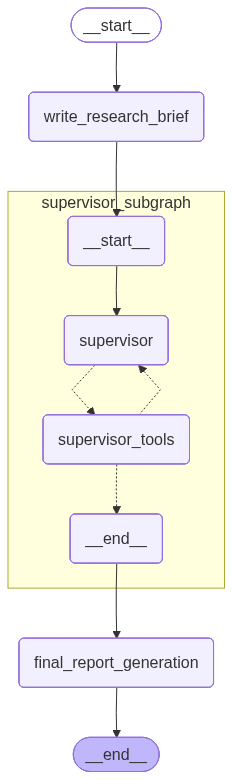

In [8]:
# Run the workflow
# from deep_research.utils import format_messages

from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=-1).draw_mermaid_png()))

In [9]:
import json 
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_upstage import ChatUpstage
llm = ChatUpstage(api_key=os.getenv("UPSTAGE_API_KEY"), model="solar-pro2")


# ✅ final_report 기반 한 줄 답 체인
one_line_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
당신은 한국어 최신성 QA 시스템의 마지막 단계입니다.

역할:
- 이전 단계에서 수행된 리서치 결과(final_report JSON)를 보고,
  Ko-FreshQA 리더보드 제출용 "최종 답변 한 줄"만 생성합니다.

출력 규칙:
1. 반드시 **질문에 대한 직접적인 정답만** 한국어로 출력하세요.
2. 불필요한 문장/접두어/추가 설명은 절대 쓰지 마세요.
   - 예: "제 지식은 ~까지입니다", "제가 아는 한", "추가로 말씀드리면" 금지.
3. 답변은 최대 1문장으로 짧게. (정말 필요할 때만 2문장)
4. 나이/날짜/개수/순번은 명확한 숫자로 답하세요.
   - 예) "23세입니다.", "2025년 8월 15일입니다.", "제31차 정상회의였습니다."
5. 확실하지 않은 정보는 추측하지 말고:
   - "잘 모르겠습니다." 한 문장만 출력하세요.
6. 정답에 필요한 핵심 정보만 포함하고, 나머지 부가 설명은 모두 제거합니다.
""".strip(),
        ),
        (
            "user",
            """
[질문]
{question}

[final_report JSON]
{final_report_json}

위 정보를 모두 고려해서,
Ko-FreshQA 리더보드 제출용 최종 답변 한 줄만 출력하세요.
""".strip(),
        ),
    ]
)

one_line_chain = one_line_prompt | llm | StrOutputParser()


In [10]:
import os
import uuid
import json
import pandas as pd
from dotenv import load_dotenv
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage
from deep_research.research_agent_full import deep_researcher_builder
from concurrent.futures import ThreadPoolExecutor, as_completed

load_dotenv()

# DEV/리더보드용 에이전트 (가능하면 FAST 모드로!)
checkpointer = InMemorySaver()
agent = deep_researcher_builder.compile(checkpointer=checkpointer)
# 만약 builder가 mode를 받게 만들었다면:
# agent = deep_researcher_builder(mode="fast").compile(checkpointer=checkpointer)


def run_agent_once(question: str) -> str:
    """
    1) 딥리서치 그래프 실행해서 final_report(JSON)를 얻고
    2) 그 JSON을 ChatUpstage 기반 LangChain 체인에 넣어 Ko-FreshQA용 한 줄 정답을 생성한다.
    """

    thread_cfg = {
        "configurable": {
            "thread_id": str(uuid.uuid4()),
            "recursion_limit": 10,
        }
    }

    # 1) LangGraph 딥리서치 실행
    state = agent.invoke(
        {"messages": [HumanMessage(content=question)]},
        config=thread_cfg,
    )

    final_report = state.get("final_report", {})
    try:
        final_report_json = json.dumps(final_report, ensure_ascii=False, indent=2)
    except TypeError:
        final_report_json = str(final_report)

    # 2) ChatUpstage + LangChain 체인으로 한 줄 정답 생성
    one_line_answer = one_line_chain.invoke(
        {
            "question": question,
            "final_report_json": final_report_json,
        }
    )

    # 안전하게 한 줄만 남기기
    if isinstance(one_line_answer, str):
        one_line_answer = one_line_answer.strip()
        if "\n" in one_line_answer:
            one_line_answer = one_line_answer.splitlines()[0].strip()
    else:
        one_line_answer = str(one_line_answer)

    return one_line_answer



def process_row(idx: int, row) -> tuple[int, str]:
    """ThreadPool에서 쓸 함수: 인덱스와 질문을 받아 답을 돌려줌."""
    question = row["question"]
    print(f"[Thread] idx={idx}, question={question}")
    ans = run_agent_once(question)
    return idx, ans


def main():
    input_path = "ko-freshqa_2025_dev.csv"
    output_path = "ko-freshqa_2025_dev_with_model.csv"

    df = pd.read_csv(input_path, encoding="utf-8")
    df["model_response"] = ""  # 미리 컬럼 생성

    max_workers = 4  # 머신/비용 보고 4~8 정도로 조절

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(process_row, idx, row)
            for idx, row in df.iterrows()
        ]

        for i, fut in enumerate(as_completed(futures), start=1):
            idx, ans = fut.result()
            df.at[idx, "model_response"] = ans
            print(f"[{i}/{len(futures)}] idx={idx} 완료 → {ans}")

    df.to_csv(output_path, index=False, encoding="utf-8")
    print("저장 완료:", output_path)


if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'pandas'